In [35]:
%%capture
# Cell 1: Install dependencies
%pip install -q --root-user-action=ignore "numpy==1.26.4" "scipy==1.13.1" "ultralytics==8.3.49" "filterpy==1.4.5" "seaborn"

import os, math, time, glob, cv2, random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import datetime
from ultralytics import YOLO
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [36]:
# Cell 2: Paths and sequence definitions
BASE_DIR = "/kaggle/input/adspmini02"
TRAIN_VIDEO_DIR = os.path.join(BASE_DIR, "Train", "vedios")
TRAIN_GT_DIR = os.path.join(BASE_DIR, "Train", "gt")
TEST_VIDEO_DIR = os.path.join(BASE_DIR, "Test", "vedios")
TEST_GT_DIR = os.path.join(BASE_DIR, "Test", "gt")
OUTPUT_DIR = "/kaggle/working/wildlife_tracking"
YOLO_BASE = "/kaggle/working/yolo_data"
RUN_ROOT = "/kaggle/working"  # Added missing variable

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_BASE, exist_ok=True)

def build_sequences(video_dir, gt_dir):
    seqs = {}
    if os.path.exists(video_dir):
        for pattern in ("*.mp4", "*.avi", "*.mov"):
            for vpath in sorted(glob.glob(os.path.join(video_dir, pattern))):
                base = os.path.splitext(os.path.basename(vpath))[0]
                seqs.setdefault(base, {})["video"] = vpath
    if os.path.exists(gt_dir):
        for gpath in sorted(glob.glob(os.path.join(gt_dir, "*.txt"))):
            base = os.path.splitext(os.path.basename(gpath))[0]
            if base.endswith("_gt"): base = base[:-3]
            seqs.setdefault(base, {})["gt"] = gpath
    for k, v in seqs.items():
        v.setdefault("video", None)
        v.setdefault("gt", None)
    return seqs

train_seqs = build_sequences(TRAIN_VIDEO_DIR, TRAIN_GT_DIR)
test_seqs = build_sequences(TEST_VIDEO_DIR, TEST_GT_DIR)
print(f"Train: {len(train_seqs)} sequences | Test: {len(test_seqs)} sequences")

Train: 14 sequences | Test: 5 sequences


In [37]:
# Cell 3: GT loader and class discovery
def load_gt_file(gt_path):
    cols = ["frame", "gt_id", "x", "y", "w", "h", "conf", "cls", "vis"]
    df = pd.read_csv(gt_path, header=None, names=cols, sep=r"[,\s]+", engine="python")
    df = df[["frame", "gt_id", "x", "y", "w", "h", "cls"]].copy()
    df["frame"] = df["frame"].astype(int)
    df["gt_id"] = df["gt_id"].astype(int)
    df["cls"] = df["cls"].astype(int)
    return df

ALL_CLASSES = set()
for seqs in (train_seqs, test_seqs):
    for seq_name, paths in seqs.items():
        gpath = paths.get("gt")
        if gpath and os.path.exists(gpath):
            df = load_gt_file(gpath)
            if not df.empty: ALL_CLASSES.update(df["cls"].unique().tolist())

ALL_CLASSES = sorted(int(c) for c in ALL_CLASSES)
cls_to_new = {old: i for i, old in enumerate(ALL_CLASSES)}
NC = len(ALL_CLASSES)
print(f"Classes: {ALL_CLASSES} | Remap: {cls_to_new}")

Classes: [2, 6, 8] | Remap: {2: 0, 6: 1, 8: 2}


In [38]:
# Cell 4: Export Train/Test to YOLO format
IMGS_TRAIN_DIR = os.path.join(YOLO_BASE, "images", "train")
IMGS_VAL_DIR = os.path.join(YOLO_BASE, "images", "val")
LBL_TRAIN_DIR = os.path.join(YOLO_BASE, "labels", "train")
LBL_VAL_DIR = os.path.join(YOLO_BASE, "labels", "val")
for d in [IMGS_TRAIN_DIR, IMGS_VAL_DIR, LBL_TRAIN_DIR, LBL_VAL_DIR]: os.makedirs(d, exist_ok=True)

def export_split_to_yolo(split_name, seq_dict, img_out_dir, lbl_out_dir):
    print(f"\nExporting {split_name}...")
    for seq_name, paths in seq_dict.items():
        video_path, gt_path = paths["video"], paths["gt"]
        if not video_path or not gt_path: continue
        gt_df = load_gt_file(gt_path)
        if gt_df.empty: continue
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): continue
        w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            sub = gt_df[gt_df["frame"] == frame_idx]
            if sub.empty: continue
            img_name = f"{seq_name}_{frame_idx:06d}.jpg"
            cv2.imwrite(os.path.join(img_out_dir, img_name), frame)
            lines = []
            for _, row in sub.iterrows():
                x, y, bw, bh = row["x"], row["y"], row["w"], row["h"]
                cls_new = cls_to_new[int(row["cls"])]
                xc, yc = (x + bw/2)/w, (y + bh/2)/h
                lines.append(f"{cls_new} {xc:.6f} {yc:.6f} {bw/w:.6f} {bh/h:.6f}")
            with open(os.path.join(lbl_out_dir, img_name.replace(".jpg", ".txt")), "w") as f:
                f.write("\n".join(lines))
        cap.release()
        print(f"  Done: {seq_name}")

export_split_to_yolo("Train", train_seqs, IMGS_TRAIN_DIR, LBL_TRAIN_DIR)
export_split_to_yolo("Test", test_seqs, IMGS_VAL_DIR, LBL_VAL_DIR)
print("\nYOLO export done.")


Exporting Train...
  Done: deer_1
  Done: deer_2
  Done: deer_3
  Done: deer_4
  Done: deer_7
  Done: horse_3
  Done: horse_4
  Done: horse_5
  Done: horse_6
  Done: horse_7
  Done: pig_1
  Done: pig_2
  Done: pig_3
  Done: pig_5

Exporting Test...
  Done: deer_5
  Done: deer_6
  Done: horse_1
  Done: horse_2
  Done: pig_4

YOLO export done.


In [39]:
# Cell 5: Create data.yaml
names_list = [f"cls{c}" for c in ALL_CLASSES]
data_yaml = f"""path: {YOLO_BASE}
train: images/train
val: images/val
nc: {NC}
names: {names_list}
"""
yaml_path = os.path.join(YOLO_BASE, "data.yaml")
with open(yaml_path, "w") as f: f.write(data_yaml)
print("data.yaml created")

data.yaml created


In [40]:
# Fix: Disable Ray Tune callback to avoid compatibility issues
import ultralytics.utils.callbacks.raytune as raytune_callbacks
raytune_callbacks.callbacks = {}
print("Ray Tune callbacks disabled - compatibility fix applied")

Ray Tune callbacks disabled - compatibility fix applied


In [41]:
# import torch, gc

# def clear_gpu():
#     gc.collect()
#     torch.cuda.empty_cache()
#     torch.cuda.ipc_collect()

# clear_gpu()


In [42]:
# Cell 6: Train YOLO
det_model = YOLO("yolov8n.pt")
results = det_model.train(data=yaml_path, imgsz=640, epochs=20, batch=64, name="wildlife_det", exist_ok=True)
try: save_dir = det_model.trainer.save_dir
except: save_dir = os.path.join(RUN_ROOT, "runs", "detect", "wildlife_det")
print(f"\nTraining done. Save dir: {save_dir}")

train: Scanning /kaggle/working/yolo_data/labels/train.cache... 6430 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6430/6430 [00:00<?, ?it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /kaggle/working/yolo_data/labels/val.cache... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:00<?, ?it/s]
       1/20      10.7G      1.267      1.643      1.155        704        640: 100%|██████████| 101/101 [01:45<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:16<00:00,  1.34s/it]
       2/20      12.8G      1.047     0.7662       1.05       1002        640: 100%|██████████| 101/101 [01:31<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 


Training done. Save dir: runs/detect/wildlife_det


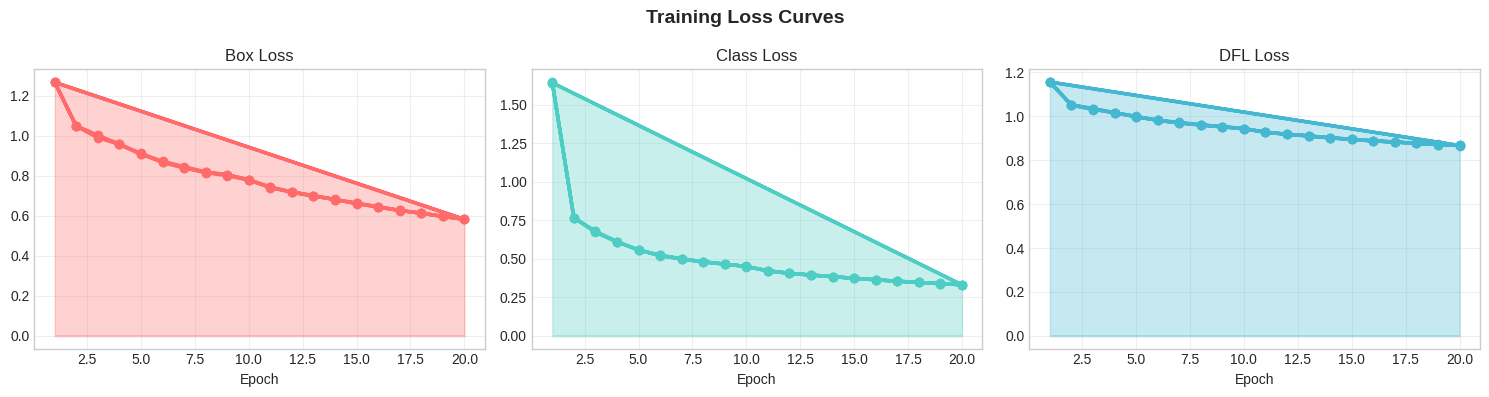

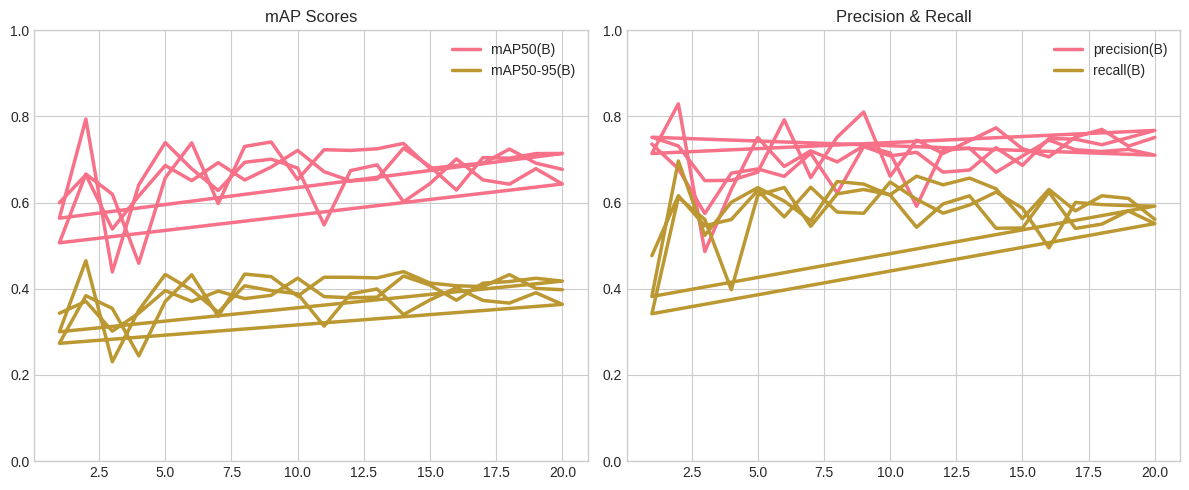

Best Epoch: 2 | mAP50: 0.7940


In [43]:
# Cell 7: Training Visualization
results_csv = os.path.join(save_dir, "results.csv") if save_dir else None
if results_csv and os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    df.columns = [c.strip() for c in df.columns]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Training Loss Curves', fontsize=14, fontweight='bold')
    loss_cols = [('train/box_loss', 'Box Loss', '#FF6B6B'), ('train/cls_loss', 'Class Loss', '#4ECDC4'), ('train/dfl_loss', 'DFL Loss', '#45B7D1')]
    for idx, (col, name, color) in enumerate(loss_cols):
        if col in df.columns:
            axes[idx].plot(df['epoch'], df[col], color=color, linewidth=2.5, marker='o')
            axes[idx].fill_between(df['epoch'], df[col], alpha=0.3, color=color)
            axes[idx].set_title(name); axes[idx].set_xlabel('Epoch'); axes[idx].grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'losses.png'), dpi=150); plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    map_cols = [c for c in df.columns if 'mAP' in c]
    for col in map_cols[:2]: axes[0].plot(df['epoch'], df[col], label=col.replace('metrics/', ''), linewidth=2.5)
    axes[0].set_title('mAP Scores'); axes[0].legend(); axes[0].set_ylim(0, 1)
    pr_cols = [c for c in df.columns if 'precision' in c.lower() or 'recall' in c.lower()]
    for col in pr_cols[:2]: axes[1].plot(df['epoch'], df[col], label=col.replace('metrics/', ''), linewidth=2.5)
    axes[1].set_title('Precision & Recall'); axes[1].legend(); axes[1].set_ylim(0, 1)
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'metrics.png'), dpi=150); plt.show()
    
    best_col = 'metrics/mAP50(B)' if 'metrics/mAP50(B)' in df.columns else None
    if best_col:
        best_row = df.loc[df[best_col].idxmax()]
        print(f"Best Epoch: {int(best_row['epoch'])} | mAP50: {best_row[best_col]:.4f}")

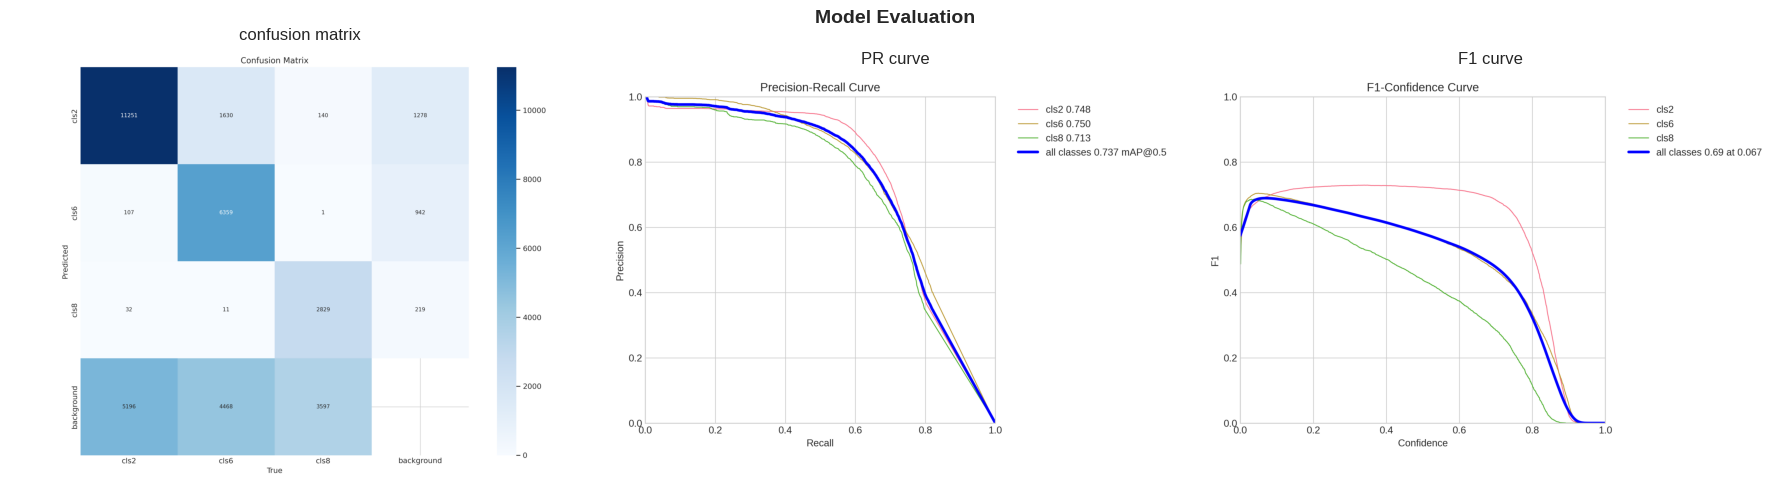

In [44]:
# Cell 7b: Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Evaluation', fontsize=14, fontweight='bold')
for idx, name in enumerate(['confusion_matrix.png', 'PR_curve.png', 'F1_curve.png']):
    p = os.path.join(save_dir, name) if save_dir else None
    if p and os.path.exists(p):
        axes[idx].imshow(Image.open(p)); axes[idx].axis('off')
        axes[idx].set_title(name.replace('.png', '').replace('_', ' '))
    else: axes[idx].text(0.5, 0.5, 'Not Available', ha='center'); axes[idx].axis('off')
plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'evaluation.png'), dpi=150); plt.show()

In [45]:
# Cell 8: Feature extraction helpers
def extract_color_hist(img, bbox, bins=(16, 16, 16)):
    x1, y1, x2, y2 = [int(v) for v in bbox]
    h, w = img.shape[:2]
    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w-1, x2), min(h-1, y2)
    if x2 <= x1 or y2 <= y1: return np.zeros(bins[0]*bins[1]*bins[2], dtype=np.float32)
    patch = img[y1:y2, x1:x2]
    if patch.size == 0: return np.zeros(bins[0]*bins[1]*bins[2], dtype=np.float32)
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten().astype(np.float32)

def cosine_distance(f1, f2):
    if f1 is None or f2 is None: return 1.0
    f1, f2 = np.asarray(f1, dtype=np.float32), np.asarray(f2, dtype=np.float32)
    return 1.0 - float(np.dot(f1, f2)) / (float(np.linalg.norm(f1)) + 1e-6) / (float(np.linalg.norm(f2)) + 1e-6)

def bbox_iou_cost(box1, box2):
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, x2-x1) * max(0, y2-y1)
    union = (box1[2]-box1[0])*(box1[3]-box1[1]) + (box2[2]-box2[0])*(box2[3]-box2[1]) - inter + 1e-6
    return 1.0 - inter/union

In [46]:
# Cell 9: Improved Tracker
class Track:
    def __init__(self, track_id, bbox, feature, frame_idx, cls=None, dt=1.0):
        self.id, self.bbox, self.feature, self.last_frame = track_id, bbox, feature, frame_idx
        self.age, self.hits, self.misses, self.cls = 1, 1, 0, cls
        cx, cy = (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2
        w, h = bbox[2]-bbox[0], bbox[3]-bbox[1]
        self.kf = KalmanFilter(dim_x=6, dim_z=4)
        self.kf.x = np.array([cx, cy, w, h, 0., 0.], dtype=float)
        self.kf.F = np.array([[1,0,0,0,dt,0],[0,1,0,0,0,dt],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]], dtype=float)
        self.kf.H = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0]], dtype=float)
        self.kf.P *= 100.; self.kf.R *= 5.; self.kf.Q *= 0.05

    def predict(self):
        self.kf.predict()
        cx, cy, w, h = self.kf.x[:4].flatten()
        return (cx-w/2, cy-h/2, cx+w/2, cy+h/2)

    def update(self, bbox, feature, frame_idx, cls=None):
        self.bbox, self.last_frame = bbox, frame_idx
        self.age += 1; self.hits += 1; self.misses = 0
        if self.feature is not None and feature is not None:
            self.feature = 0.7*self.feature + 0.3*feature
        else: self.feature = feature
        if cls is not None: self.cls = int(cls)
        cx, cy = (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2
        self.kf.update(np.array([cx, cy, bbox[2]-bbox[0], bbox[3]-bbox[1]]))

    def mark_missed(self): self.misses += 1; self.age += 1
    def get_predicted_bbox(self):
        cx, cy, w, h = self.kf.x[:4].flatten()
        return (cx-w/2, cy-h/2, cx+w/2, cy+h/2)

class MultiObjectTracker:
    def __init__(self, max_missed=20, iou_weight=0.5, appearance_weight=0.5, max_match_distance=0.6, min_hits=3):
        self.next_id, self.tracks = 1, []
        self.max_missed, self.iou_weight, self.appearance_weight = max_missed, iou_weight, appearance_weight
        self.max_match_distance, self.min_hits = max_match_distance, min_hits

    def _compute_cost(self, tracks, detections):
        if not tracks or not detections: return np.zeros((len(tracks), len(detections)))
        cost = np.zeros((len(tracks), len(detections)))
        for i, trk in enumerate(tracks):
            pred_box = trk.get_predicted_bbox()
            for j, det in enumerate(detections):
                iou_dist = bbox_iou_cost(pred_box, det["bbox"])
                app_dist = cosine_distance(trk.feature, det["feature"])
                cls_penalty = 0.5 if (trk.cls is not None and det.get("cls") is not None and trk.cls != det["cls"]) else 0
                cost[i,j] = self.iou_weight*iou_dist + self.appearance_weight*app_dist + cls_penalty
        return cost

    def update(self, detections, frame_idx):
        for trk in self.tracks: trk.predict()
        if self.tracks and detections:
            C = self._compute_cost(self.tracks, detections)
            row_idx, col_idx = linear_sum_assignment(C)
            matches, unmatched_t, unmatched_d = [], set(range(len(self.tracks))), set(range(len(detections)))
            for r, c in zip(row_idx, col_idx):
                if C[r,c] <= self.max_match_distance:
                    matches.append((r,c)); unmatched_t.discard(r); unmatched_d.discard(c)
        else:
            matches, unmatched_t, unmatched_d = [], set(range(len(self.tracks))), set(range(len(detections)))
        for t_idx, d_idx in matches:
            det = detections[d_idx]
            self.tracks[t_idx].update(det["bbox"], det["feature"], frame_idx, det.get("cls"))
        for t_idx in unmatched_t: self.tracks[t_idx].mark_missed()
        for d_idx in unmatched_d:
            det = detections[d_idx]
            self.tracks.append(Track(self.next_id, det["bbox"], det["feature"], frame_idx, det.get("cls")))
            self.next_id += 1
        self.tracks = [t for t in self.tracks if t.misses <= self.max_missed]
        return self.tracks

    def get_confirmed(self): return [t for t in self.tracks if t.hits >= self.min_hits]

In [47]:
# Cell 10: Run Tracking (FIXED - new tracker per sequence)
DEVICE = 0 if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")

raw_names = getattr(det_model.model, "names", {})
CLASS_NAMES = {int(k): v for k, v in raw_names.items()} if isinstance(raw_names, dict) else {i: n for i, n in enumerate(raw_names)}
CLASS_NAMES.update({0: "deer", 1: "horse", 2: "pig"})

all_tracks_records = []  # Reset before run

def run_on_split(split_name, seq_dict):
    global all_tracks_records
    for seq_name, paths in seq_dict.items():
        video_path = paths["video"]
        if not video_path or not os.path.exists(video_path): continue
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): continue
        
        tracker = MultiObjectTracker(max_missed=20, iou_weight=0.5, appearance_weight=0.5, max_match_distance=0.6)  # Fresh per video!
        
        fps = cap.get(cv2.CAP_PROP_FPS) or 25
        w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        out_path = os.path.join(OUTPUT_DIR, f"{split_name}_{seq_name}_tracked.mp4")
        out_writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
        print(f"Processing {split_name}/{seq_name}...")
        
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            results = det_model.predict(source=frame, imgsz=640, conf=0.4, verbose=False, device=DEVICE)
            detections = []
            for r in results:
                if r.boxes is None: continue
                for box in r.boxes:
                    cls = int(box.cls)
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    detections.append({"bbox": (x1,y1,x2,y2), "center": ((x1+x2)/2, (y1+y2)/2), "cls": cls, "feature": extract_color_hist(frame, (x1,y1,x2,y2))})
            
            tracker.update(detections, frame_idx)
            for trk in tracker.get_confirmed():
                x1,y1,x2,y2 = map(int, trk.bbox)
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)
                label = f"{CLASS_NAMES.get(trk.cls, 'unk')} ID{trk.id}"
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,255,0), 2)
                all_tracks_records.append([split_name, seq_name, frame_idx, trk.id, trk.cls, x1, y1, x2, y2, trk.hits, trk.misses])
            out_writer.write(frame)
        cap.release(); out_writer.release()
        print(f"  Saved: {out_path}")

run_on_split("Train", train_seqs)
run_on_split("Test", test_seqs)

tracks_df = pd.DataFrame(all_tracks_records, columns=["split","seq","frame","track_id","cls","x1","y1","x2","y2","hits","misses"])
tracks_df.to_csv(os.path.join(OUTPUT_DIR, "tracks.csv"), index=False)
print(f"\nSaved tracks.csv with {len(tracks_df)} records")

Device: 0
Processing Train/deer_1...
  Saved: /kaggle/working/wildlife_tracking/Train_deer_1_tracked.mp4
Processing Train/deer_2...
  Saved: /kaggle/working/wildlife_tracking/Train_deer_2_tracked.mp4
Processing Train/deer_3...
  Saved: /kaggle/working/wildlife_tracking/Train_deer_3_tracked.mp4
Processing Train/deer_4...
  Saved: /kaggle/working/wildlife_tracking/Train_deer_4_tracked.mp4
Processing Train/deer_7...
  Saved: /kaggle/working/wildlife_tracking/Train_deer_7_tracked.mp4
Processing Train/horse_3...
  Saved: /kaggle/working/wildlife_tracking/Train_horse_3_tracked.mp4
Processing Train/horse_4...
  Saved: /kaggle/working/wildlife_tracking/Train_horse_4_tracked.mp4
Processing Train/horse_5...
  Saved: /kaggle/working/wildlife_tracking/Train_horse_5_tracked.mp4
Processing Train/horse_6...
  Saved: /kaggle/working/wildlife_tracking/Train_horse_6_tracked.mp4
Processing Train/horse_7...
  Saved: /kaggle/working/wildlife_tracking/Train_horse_7_tracked.mp4
Processing Train/pig_1...
  Sa

In [48]:
# Cell 11: Evaluate Tracking
def bbox_iou(a, b):
    ix1, iy1 = max(a[0], b[0]), max(a[1], b[1])
    ix2, iy2 = min(a[2], b[2]), min(a[3], b[3])
    inter = max(0, ix2-ix1) * max(0, iy2-iy1)
    union = (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter + 1e-6
    return inter / union

def evaluate_sequence(seq_name, split_name, gt_path, tracks_df, iou_thresh=0.5):
    gt_df = load_gt_file(gt_path)
    if gt_df.empty: return None
    sub = tracks_df[(tracks_df["split"]==split_name) & (tracks_df["seq"]==seq_name)]
    if sub.empty: return None
    
    track_map, total_gt, total_pred, matches, id_switches = {}, 0, 0, 0, 0
    for f in sorted(gt_df["frame"].unique()):
        gt_f, tr_f = gt_df[gt_df["frame"]==f], sub[sub["frame"]==f]
        gt_boxes, gt_ids = gt_f[["x","y","w","h"]].values, gt_f["gt_id"].values
        pred_boxes, pred_ids = tr_f[["x1","y1","x2","y2"]].values, tr_f["track_id"].values
        total_gt += len(gt_boxes); total_pred += len(pred_boxes)
        if len(gt_boxes)==0 or len(pred_boxes)==0: continue
        cost = np.zeros((len(gt_boxes), len(pred_boxes)))
        for i in range(len(gt_boxes)):
            x,y,w,h = gt_boxes[i]
            for j in range(len(pred_boxes)):
                cost[i,j] = 1.0 - bbox_iou((x,y,x+w,y+h), tuple(pred_boxes[j]))
        row_idx, col_idx = linear_sum_assignment(cost)
        for r, c in zip(row_idx, col_idx):
            if 1.0-cost[r,c] >= iou_thresh:
                gid, tid = int(gt_ids[r]), int(pred_ids[c])
                matches += 1
                if gid in track_map and track_map[gid] != tid: id_switches += 1
                track_map[gid] = tid
    fp, fn = max(0, total_pred-matches), max(0, total_gt-matches)
    return {"split": split_name, "seq": seq_name, "gt": total_gt, "pred": total_pred, "matches": matches,
            "FP": fp, "FN": fn, "IDsw": id_switches, "MOTA": 1-(fp+fn+id_switches)/(total_gt+1e-6),
            "precision": matches/(total_pred+1e-6), "recall": matches/(total_gt+1e-6)}

results = []
for split_name, seq_dict in [("Train", train_seqs), ("Test", test_seqs)]:
    for seq_name, paths in seq_dict.items():
        if paths["gt"] and os.path.exists(paths["gt"]):
            res = evaluate_sequence(seq_name, split_name, paths["gt"], tracks_df)
            if res: results.append(res)

metrics_df = pd.DataFrame(results)
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "tracking_metrics.csv"), index=False)
display(metrics_df)

split      seq     gt   pred  matches    FP    FN  IDsw      MOTA  \
0   Train   deer_1   2412   2705     2344   361    68    79  0.789386   
1   Train   deer_2   7214   8379     7044  1335   170    61  0.782922   
2   Train   deer_3   4861   5418     4774   644    87    30  0.843448   
3   Train   deer_4   2462   2824     2438   386    24    13  0.828188   
4   Train   deer_7   4989   5291     4936   355    53    16  0.915013   
5   Train  horse_3  15930  18093    15616  2477   314    74  0.820151   
6   Train  horse_4   3731   3744     3688    56    43     5  0.972125   
7   Train  horse_5   5603   5775     5528   247    75     4  0.941817   
8   Train  horse_6   7879   8398     7736   662   143    49  0.891611   
9   Train  horse_7  10091  10555     9913   642   178    34  0.915370   
10  Train    pig_1   2623   3277     2565   712    58    29  0.695387   
11  Train    pig_2  10854  12607    10671  1936   183    71  0.798231   
12  Train    pig_3   6761   7048     6709   339    52    13  0.940246   
13  Train    pig_5   5468   6724     5308  1416   160    70  0.698976   
14   Test   deer_5   1771    132      116    16  1655     1  0.055901   
15   Test   deer_6  14815  12485    10949  1536  3866   104  0.628350   
16   Test  horse_1   6653   6644     4754  1890  1899   147  0.408387   
17   Test  horse_2   5815   4770     3566  1204  2249   209  0.370249   
18   Test    pig_4   6567   3900     2889  1011  3678    28  0.281712   

    precision    recall  
0    0.866543  0.971808  
1    0.840673  0.976435  
2    0.881137  0.982102  
3    0.863314  0.990252  
4    0.932905  0.989377  
5    0.863096  0.980289  
6    0.985043  0.988475  
7    0.957229  0.986614  
8    0.921172  0.981850  
9    0.939176  0.982361  
10   0.782728  0.977888  
11   0.846435  0.983140  
12   0.951901  0.992309  
13   0.789411  0.970739  
14   0.878788  0.065500  
15   0.876972  0.739048  
16   0.715533  0.714565  
17   0.747589  0.613242  
18   0.740769  0.439927

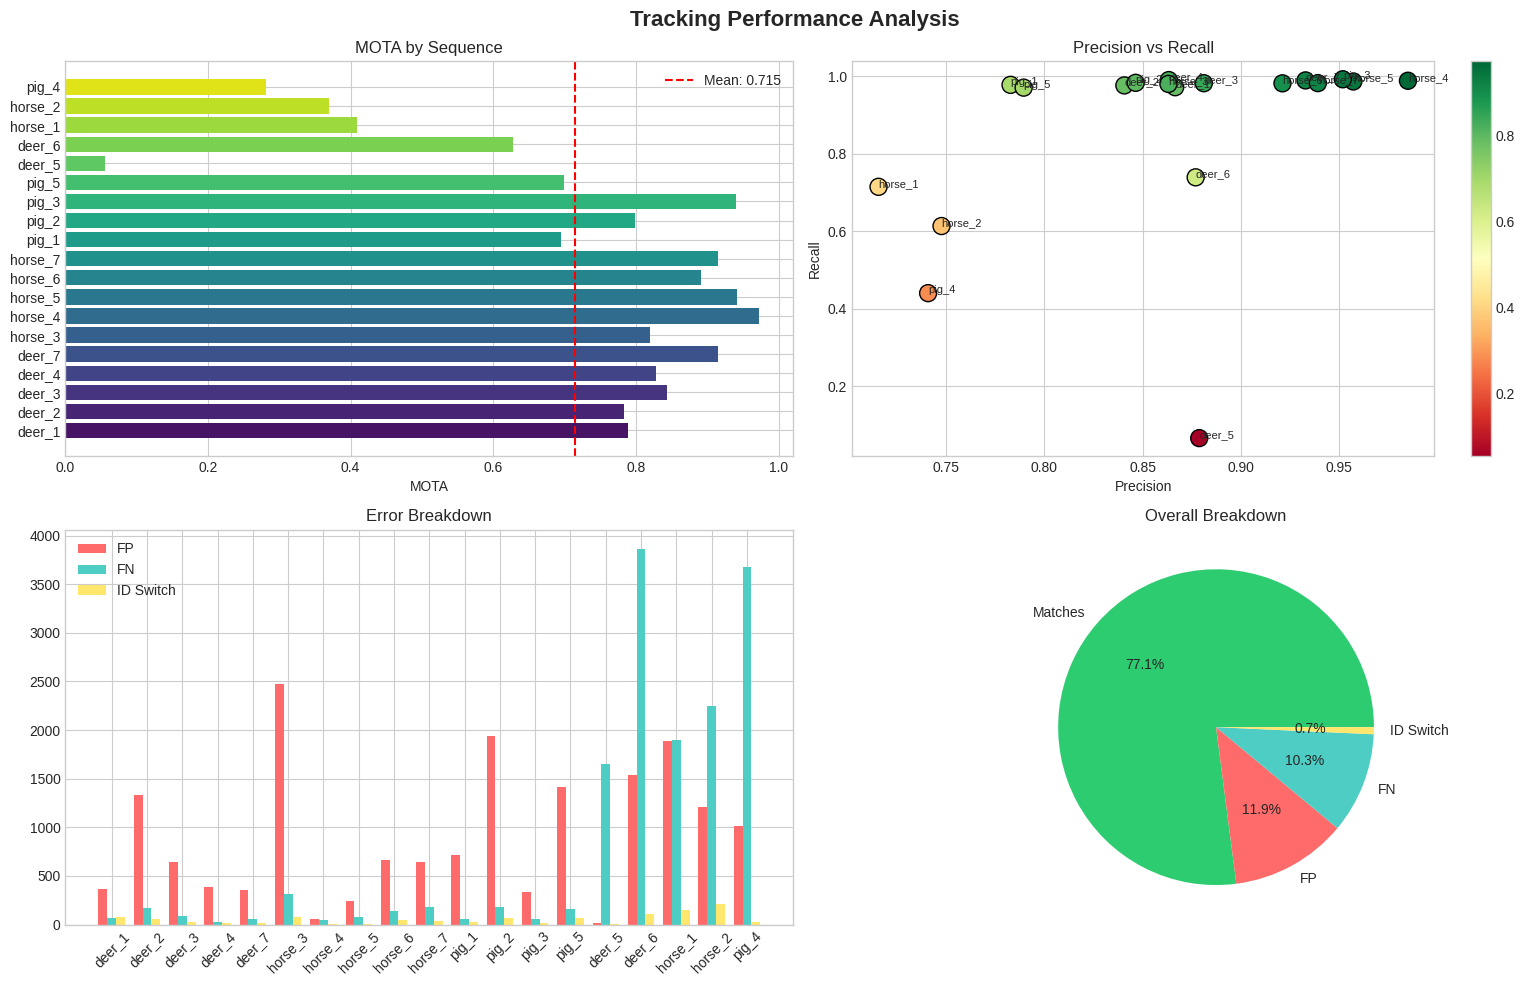


Mean MOTA: 0.7146 | Mean Precision: 0.8621 | Mean Recall: 0.8593


In [49]:
# Cell 12: Tracking Metrics Visualization
if not metrics_df.empty:
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Tracking Performance Analysis', fontsize=16, fontweight='bold')
    
    ax1 = fig.add_subplot(2, 2, 1)
    bars = ax1.barh(metrics_df['seq'], metrics_df['MOTA'], color=sns.color_palette('viridis', len(metrics_df)))
    ax1.axvline(x=metrics_df['MOTA'].mean(), color='red', linestyle='--', label=f"Mean: {metrics_df['MOTA'].mean():.3f}")
    ax1.set_xlabel('MOTA'); ax1.set_title('MOTA by Sequence'); ax1.legend()
    
    ax2 = fig.add_subplot(2, 2, 2)
    scatter = ax2.scatter(metrics_df['precision'], metrics_df['recall'], c=metrics_df['MOTA'], cmap='RdYlGn', s=150, edgecolors='black')
    for i, row in metrics_df.iterrows(): ax2.annotate(row['seq'], (row['precision'], row['recall']), fontsize=8)
    ax2.set_xlabel('Precision'); ax2.set_ylabel('Recall'); ax2.set_title('Precision vs Recall'); plt.colorbar(scatter, ax=ax2)
    
    ax3 = fig.add_subplot(2, 2, 3)
    x = np.arange(len(metrics_df)); w = 0.25
    ax3.bar(x-w, metrics_df['FP'], w, label='FP', color='#FF6B6B')
    ax3.bar(x, metrics_df['FN'], w, label='FN', color='#4ECDC4')
    ax3.bar(x+w, metrics_df['IDsw'], w, label='ID Switch', color='#FFE66D')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics_df['seq'], rotation=45); ax3.legend(); ax3.set_title('Error Breakdown')
    
    ax4 = fig.add_subplot(2, 2, 4)
    sizes = [metrics_df['matches'].sum(), metrics_df['FP'].sum(), metrics_df['FN'].sum(), metrics_df['IDsw'].sum()]
    ax4.pie(sizes, labels=['Matches', 'FP', 'FN', 'ID Switch'], colors=['#2ECC71','#FF6B6B','#4ECDC4','#FFE66D'], autopct='%1.1f%%')
    ax4.set_title('Overall Breakdown')
    
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'tracking_analysis.png'), dpi=150); plt.show()
    
    print(f"\nMean MOTA: {metrics_df['MOTA'].mean():.4f} | Mean Precision: {metrics_df['precision'].mean():.4f} | Mean Recall: {metrics_df['recall'].mean():.4f}")

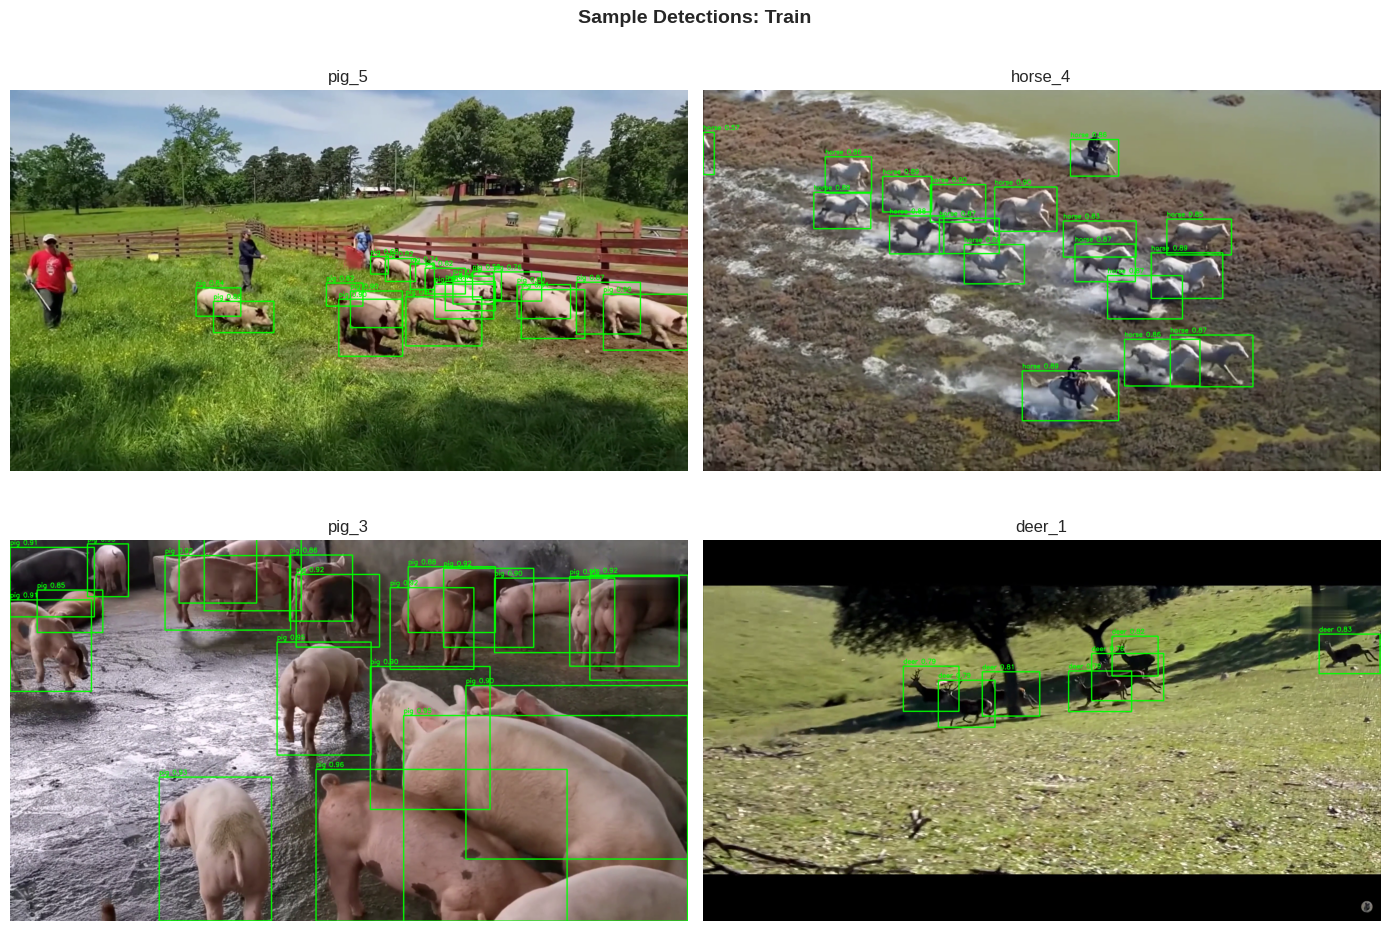

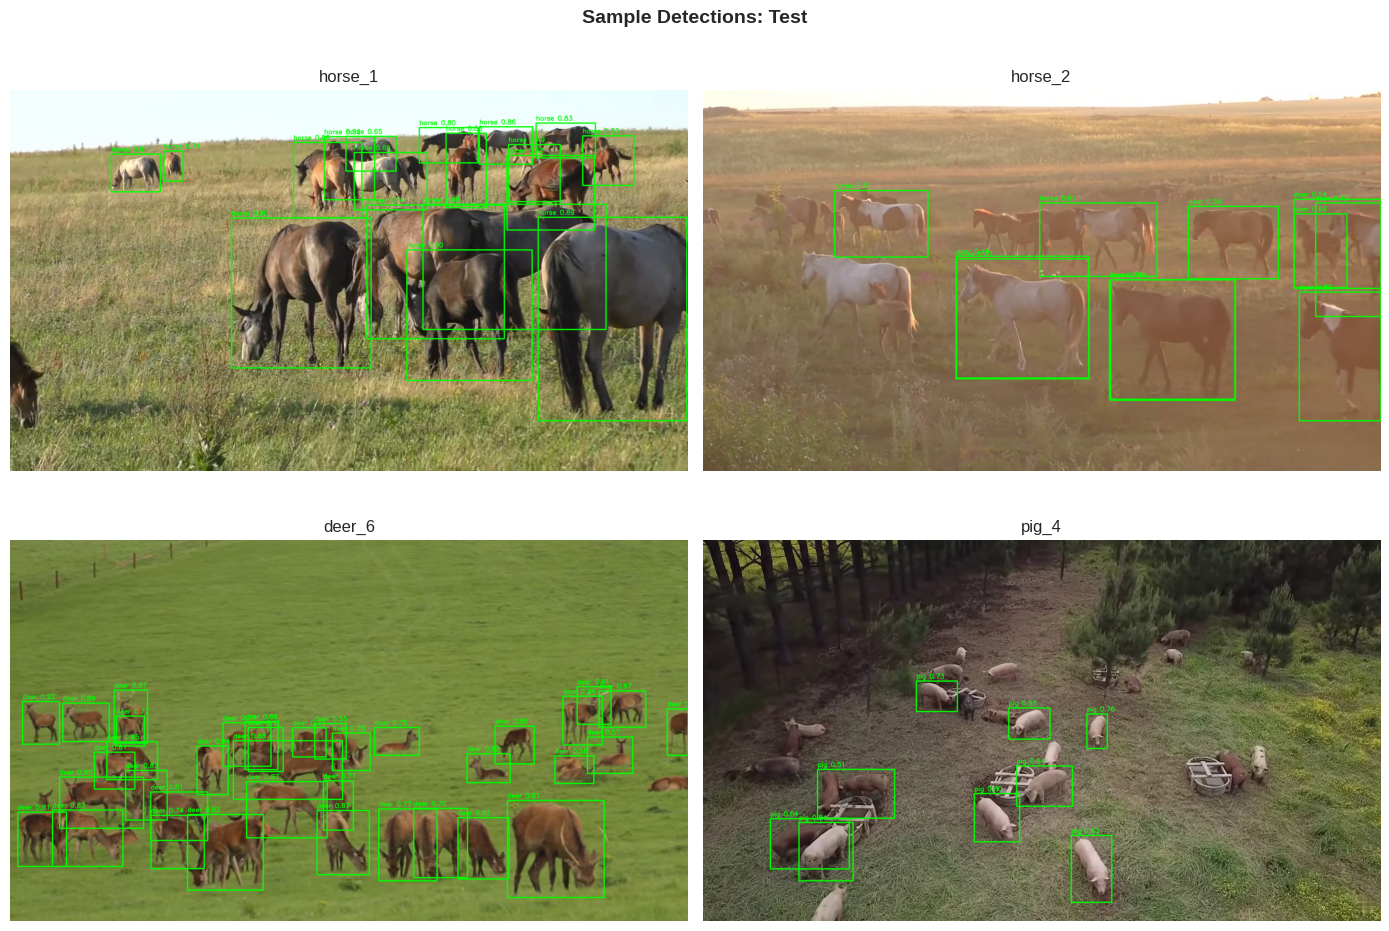

In [50]:
# Cell 13: Sample Detection Visualization
def show_samples(seq_dict, split_name, n=4):
    valid = [(k,v) for k,v in seq_dict.items() if v.get("video")]
    if not valid: return
    samples = random.sample(valid, min(n, len(valid)))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Sample Detections: {split_name}', fontsize=14, fontweight='bold')
    for idx, (seq_name, paths) in enumerate(samples):
        ax = axes.flatten()[idx]
        cap = cv2.VideoCapture(paths["video"])
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//2)
        ret, frame = cap.read(); cap.release()
        if not ret: ax.text(0.5, 0.5, 'N/A', ha='center'); ax.axis('off'); continue
        results = det_model.predict(source=frame, imgsz=640, conf=0.4, verbose=False)
        for r in results:
            if r.boxes is None: continue
            for box in r.boxes:
                x1,y1,x2,y2 = map(int, box.xyxy[0].cpu().numpy())
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)
                cv2.putText(frame, f"{CLASS_NAMES.get(int(box.cls), 'unk')} {float(box.conf):.2f}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); ax.set_title(seq_name); ax.axis('off')
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, f'samples_{split_name}.png'), dpi=150); plt.show()

show_samples(train_seqs, "Train")
show_samples(test_seqs, "Test")

In [51]:
# Cell 14: Final Summary
print("="*70)
print("WILDLIFE TRACKING PIPELINE - FINAL REPORT")
print("="*70)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nDataset: {len(train_seqs)} train + {len(test_seqs)} test sequences")
print(f"Classes: {NC} ({', '.join(CLASS_NAMES.values())})")
if not metrics_df.empty:
    print(f"\nTracking Performance:")
    print(f"  Mean MOTA:      {metrics_df['MOTA'].mean():.4f}")
    print(f"  Mean Precision: {metrics_df['precision'].mean():.4f}")
    print(f"  Mean Recall:    {metrics_df['recall'].mean():.4f}")
    print(f"  Total ID Switches: {metrics_df['IDsw'].sum()}")
print(f"\nOutput files saved to: {OUTPUT_DIR}")
print("="*70)
print("Pipeline completed!")

WILDLIFE TRACKING PIPELINE - FINAL REPORT
Generated: 2025-12-11 04:28:01

Dataset: 14 train + 5 test sequences
Classes: 3 (deer, horse, pig)

Tracking Performance:
  Mean MOTA:      0.7146
  Mean Precision: 0.8621
  Mean Recall:    0.8593
  Total ID Switches: 1037

Output files saved to: /kaggle/working/wildlife_tracking
Pipeline completed!
